In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/us-patent-phrase-to-phrase-matching/sample_submission.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv


# Data Prep

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [32]:
# load train file into df
train= pd.read_csv('../input/us-patent-phrase-to-phrase-matching/train.csv')
test= pd.read_csv('../input/us-patent-phrase-to-phrase-matching/test.csv')

In [33]:
train.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [34]:
X_train, X_test, y_train, y_test = train_test_split(train[['anchor', 'target']], train['score'], test_size=0.25, random_state=42)

In [35]:
print(len(X_train))
print(len(X_test))

27354
9119


In [36]:
print(X_train.head())
print(X_test.head())
print(y_train.head())
print(y_test.head())

                  anchor                target
10544         el display     el display device
5444      cleaner system      suction cleaners
13684       form as body  outer flank sections
14202  ftir spectrometer        image analysis
8887        deteriorated        corrugated box
                                  anchor               target
33511                     transmit alarm    display indicator
18670                  locking formation    retaining element
18049                      lateral power           transducer
31660                      spreader body             spreader
15573  high gradient magnetic separators  magnetic filtration
10544    0.50
5444     0.50
13684    0.25
14202    0.50
8887     0.25
Name: score, dtype: float64
33511    0.00
18670    0.25
18049    0.25
31660    0.75
15573    0.50
Name: score, dtype: float64


In [37]:
# add a new column with all text
X_train['text'] = X_train[['anchor', 'target']].apply(lambda x:str(x[0])+" "+str(x[1]), axis=1)

In [38]:
X_train.head()

,anchor,target,text
10544,el display,el display device,el display el display device
5444,cleaner system,suction cleaners,cleaner system suction cleaners
13684,form as body,outer flank sections,form as body outer flank sections
14202,ftir spectrometer,image analysis,ftir spectrometer image analysis
8887,deteriorated,corrugated box,deteriorated corrugated box


<AxesSubplot:ylabel='Frequency'>

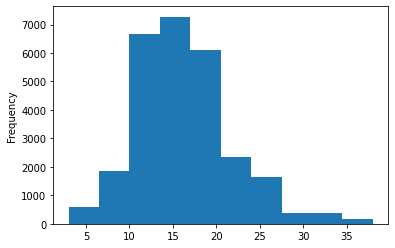

In [39]:
X_train['anchor'].str.len().plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

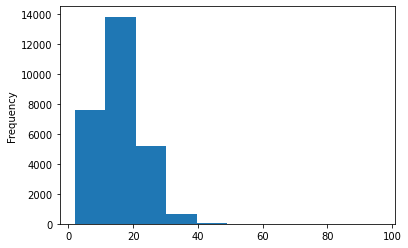

In [40]:
X_train['target'].str.len().plot(kind='hist')

In [41]:
# max len of anchor
print(max(X_train['anchor'].str.len()))

# max len of target
print(max(X_train['target'].str.len()))

38
96


In [42]:
X_train.head()

,anchor,target,text
10544,el display,el display device,el display el display device
5444,cleaner system,suction cleaners,cleaner system suction cleaners
13684,form as body,outer flank sections,form as body outer flank sections
14202,ftir spectrometer,image analysis,ftir spectrometer image analysis
8887,deteriorated,corrugated box,deteriorated corrugated box


# Tokenize Training data

In [43]:
vocab_size = 7950
max_length = 6
trunc_type='post'
oov_tok = "<OOV>"

In [44]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train['text'].values)

In [45]:
word_index = tokenizer.word_index
# len(word_index)

In [46]:
anchor_sequences = tokenizer.texts_to_sequences(X_train['anchor'].values)
target_sequences = tokenizer.texts_to_sequences(X_train['target'].values)

padded_anchor_sequences = pad_sequences(anchor_sequences, maxlen=max_length, truncating=trunc_type)
padded_target_sequences = pad_sequences(target_sequences, maxlen=max_length, truncating=trunc_type)

# Embedding layer

In [47]:
embeddings_index = {}
f = open('../input/glove6b100dtxt/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [48]:
num_tokens = vocab_size + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 7332 words (573 misses)


In [49]:
from tensorflow.keras.layers import Embedding
from tensorflow import keras

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
)

# Prepare val data

In [50]:
# Prepare val data
val_anchor_sequences = tokenizer.texts_to_sequences(X_test['anchor'].values)
val_target_sequences = tokenizer.texts_to_sequences(X_test['target'].values)

val_padded_anchor_sequences = pad_sequences(val_anchor_sequences, maxlen=max_length, truncating=trunc_type)
val_padded_target_sequences = pad_sequences(val_target_sequences, maxlen=max_length, truncating=trunc_type)

# Model Building

In [51]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras import backend as K

In [52]:
def initialize_base_network():
    input= Input(shape=(padded_anchor_sequences.shape[1],))
    
    # common_embedding= tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)(input)
    common_embedding= embedding_layer(input)
    
    common_lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.2))(common_embedding)
    #common_lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, dropout=0.2))(common_lstm_1)
    

    flatten_layer= Flatten()(common_lstm_1)
    return Model(inputs=input, outputs= flatten_layer)

In [53]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

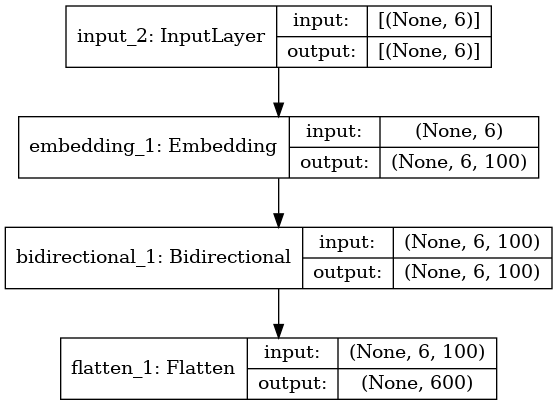

In [54]:
base_network= initialize_base_network()
plot_model(base_network, show_shapes= True)

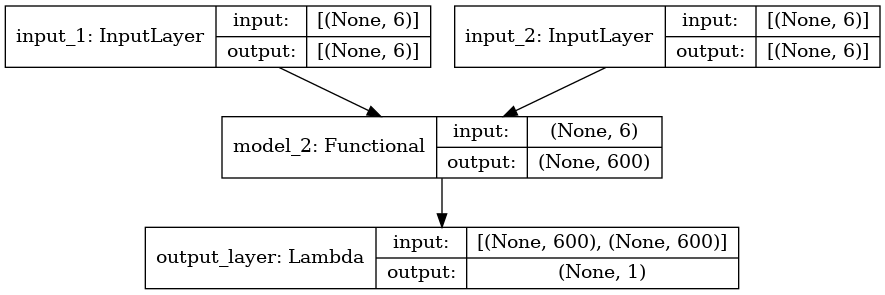

In [55]:
input_1 = Input(shape=(padded_anchor_sequences.shape[1],), name= 'input_1')
input_2 = Input(shape=(padded_target_sequences.shape[1],), name= 'input_2')

vec_1 = base_network(input_1)
vec_2 = base_network(input_2)

#output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vec_1, vec_2])
output = Lambda(euclidean_distance, name="output_layer")([vec_1, vec_2])

siamese_model = Model([input_1, input_2], output)

# plot model graph
plot_model(siamese_model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [56]:
rms = RMSprop()
siamese_model.compile(loss='mse', optimizer=rms)
siamese_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 600)          855600      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
output_layer (Lambda)           (None, 1)            0           model_2[0][0]              

In [ ]:
history = siamese_model.fit([padded_anchor_sequences,padded_target_sequences], y_train,  epochs=30,
                   batch_size=64, validation_data=([val_padded_anchor_sequences, val_padded_target_sequences],y_test))

# Prediction

In [ ]:
# Precit on val data
similarity= siamese_model.predict([val_padded_anchor_sequences, val_padded_target_sequences])

# examine shape of similarity pred
print(similarity.shape)

# reshape
similarity= similarity.reshape((len(similarity),))
print(similarity.shape)

In [ ]:
# define corr function
def corr(eval_pred): return {'pearson': np.corrcoef(*eval_pred)[0][1]}

In [ ]:
corr((similarity, y_test))